# **Predicting anomalies in critical infrastructure with photonic fiber-optic quantum sensing and QML**

# VQC Implementation on Classical Data

In the current notebook, we develop the QML module by comparing and contrasting _Variational Quantum Classifiers_ trained with "classical data" and "quantum data". The former one can be understood as the physical measurement of the photonic properties in the fiber optic cable, leading to classical bitstrings that are fed as the training data of a typical QML model. The latter one, "quantum data", refers to training a VQC with the quantum states correlated to the photons themselves from the fiber optic cable. With this analysis, we are investigating the need for QML on data that is inherently quantum and implementing QML algorithms on real quantum hardware and simulators.




**_Core algorithm_** VQC.

**_Core problem modelling_** Binary classifier — normal or anomaly.

**_Dataset origin_** Synthetic through randomized Hamiltonian evolutions that represent disturbances or temperature changes on the critical infrastructure.

In [13]:
# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, compiler, providers
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_ibm_provider import IBMProvider
from qiskit_algorithms.minimum_eigensolvers import vqe
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import Pauli, Operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

## Synthetic dataset creation

We create a randomized Hamiltonian that, if applied, models the presence of an anomaly in the infrastructure. This evolutions are taken from ensemble sensing with entanglement as seen in the Heisenberg limit. 

After initializing a N-qubit system to zeros, we apply CNOT gates to every qubit. We model the system Hamiltonian as the following:



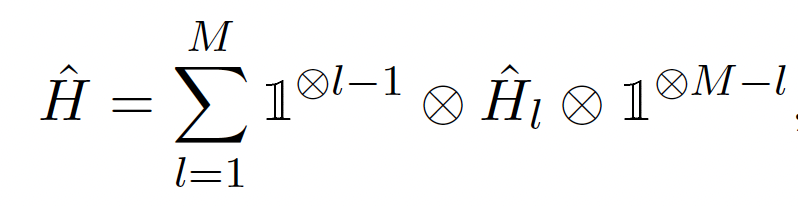

From this, it can be stated that the unitary operators to be applied to every qubit is of the below form, parameterized by a _w_0_ that will correlate to state rotations.

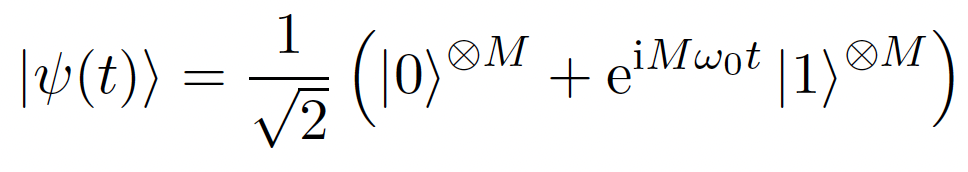

In [64]:
def str_to_list(string):
    '''
    Given a string input, it will output a list as each bit string as elements.
    '''
    new_list = []
    for i in string:
        new_list.append(int(i))
    return new_list

random_list_of_rotations = np.random.rand(4000)*2*np.pi

def hamiltonian_creation (num_qubits, w_0):
    '''
    Implementation of the w_O-parameterized Hamiltonian on a N-qubit system.
    '''
    
    # Initialize circuit and qubit states
    quantum_register = QuantumRegister(num_qubits, 'qubits')
    classical_register = ClassicalRegister(num_qubits, 'bits')
    circuit = QuantumCircuit(quantum_register, classical_register)
    circuit.h(quantum_register[0])
    circuit.cx(quantum_register[0], quantum_register[1:num_qubits])
    
    # Apply Hamiltonian to each qubit
    matrix = np.array([[1,0],[0, np.exp(-1j * w_0)]])
    operator = Operator(matrix)
    circuit.unitary(operator, quantum_register[0:num_qubits], label = 'U(w_0)')
    
    # Retrieve qubit states (for QML trained on quantum data) -> "quantum sensor"
    entangled_statevector = Statevector(circuit)
    
    # Measure qubits (for QML trained on classical data) -> "classical sensor"
    # circuit.cx(quantum_register[0], quantum_register[1:num_qubits])
    for i in range(num_qubits):
        rotation = random_list_of_rotations[i]
        circuit.ry(rotation, quantum_register[i])
    circuit.measure(quantum_register[0:num_qubits], classical_register[0:num_qubits])
    
    # To run jobs in an actual QC hardware
    # provider = IBMProvider(token = 'insert your IBMid token here')
    # backend = provider.get_backend('ibm_kyoto')
    # transpiled = transpile(circuit, backend = backend)
    # job = backend.run(transpiled, shots=1)
    # retrieved_job = provider.backend.retrieve_job(job.job_id())
    # result = str_to_list(list(retrieved_job.result().get_counts().keys())[0])
    
    # To run in simulator
    backend = AerSimulator(method = 'statevector')
    result = str_to_list(list(backend.run(circuit).result().get_counts().keys())[0])
            
    return circuit, entangled_statevector,result

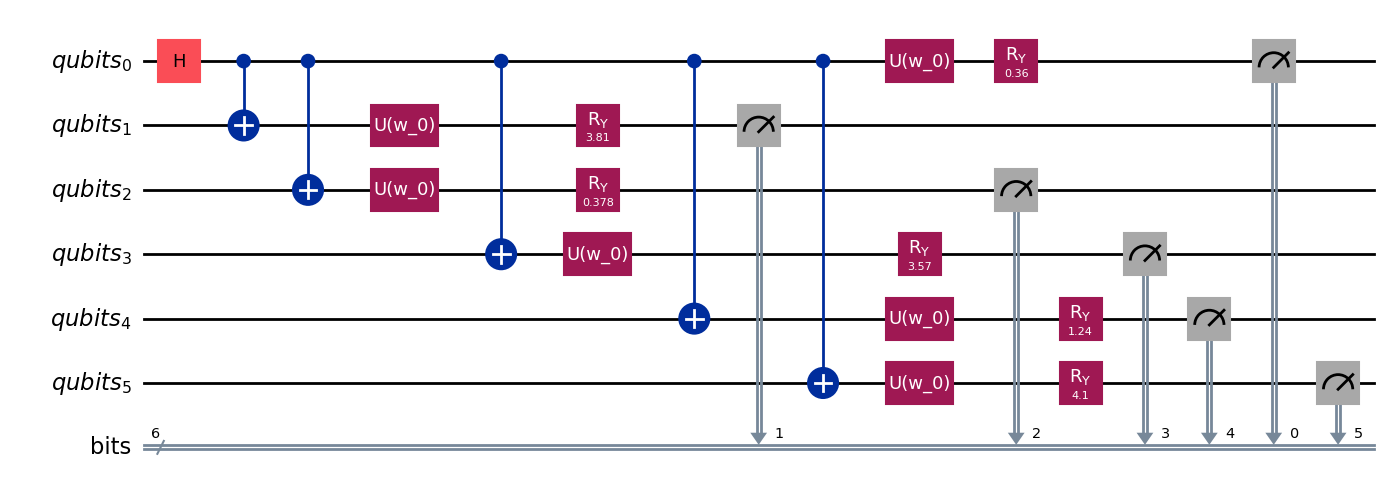

In [65]:
# Quantum circuit example ran on IBM Kyoto for 6 qubits
qubit_system_6 = hamiltonian_creation(6, 0.2)
qubit_system_6[0].draw('mpl')

We now proceed to the dataset creation from this generic implementation of the data preparation as Hamiltonian evolution. Now, for scope considerations, we define a particular model to the following:
 
- The system shall be composed of 10 qubits.
- Dataset of 200 quantum circuit instances.
- w_0 = 0 is assumed to be the normal state of the infrastructure ("-1"). 
- w_0 ≠ 0 is assumed to be an anomaly in the critical infrastructure ("1").

The synthethic data will consist of an imposed 50% "normal" states and 50% randomized w_0, that will be either anomaly or normal. Given that each w_0 is correlated to a quantum state, the QML model will infer the w_0 from the quantum state and thus generate the corresponding label.

In [66]:
# Particular model definition
row_count = 200
qubits_in_system = 4
normal_w_0 = 0
columns = ['quantum_state', 'q_0', 'q_1', 'q_2', 'q_3', 'label']
quantum_states = []
bits = [[]]
labels = []
new_rows = []

# Dataset creation
for i in range(row_count):
    if i < row_count / 2:  # Imposing 50% of normal instances
        circuit_result = hamiltonian_creation(qubits_in_system, normal_w_0)  # Each row correlates to a quantum circuit with a given Hamiltonian.
        new_row = [circuit_result[0]] + circuit_result[2] + [-1]  
    else:  # Randomising the other 50%.
        w_0_i = 0.1 * np.random.rand() * 2 * np.pi  # This could be done with a Quantum Random Number Generator also.
        circuit_result = hamiltonian_creation(qubits_in_system, w_0_i)
        
        if w_0_i == 0:  # Anomaly labelling
            new_row = [circuit_result[0]] + circuit_result[2] + [-1]
        else:
            new_row = [circuit_result[0]] + circuit_result[2] + [1]
            
    new_rows.append(new_row)
    
    
dataset = pd.DataFrame(new_rows, columns=columns)


In [67]:
# Dataset format
dataset.head()

,quantum_state,q_0,q_1,q_2,q_3,label
0,"((Instruction(name='h', num_qubits=1, num_clbi...",1,1,1,1,-1
1,"((Instruction(name='h', num_qubits=1, num_clbi...",0,0,0,0,-1
2,"((Instruction(name='h', num_qubits=1, num_clbi...",1,1,0,0,-1
3,"((Instruction(name='h', num_qubits=1, num_clbi...",0,0,0,0,-1
4,"((Instruction(name='h', num_qubits=1, num_clbi...",0,1,0,0,-1


## Variational Quantum Classifier trained on Classical Bits

Having created the synthetic dataset with both the savede quantum states and their posterior classical measurements, we proceed to create the VQCs. We select the built-in Qiskit method "score" as the target metric and criteria of comparison.

In [68]:
# Train-test split
train, test = train_test_split(dataset, test_size=0.2)
classical_train = train.drop(columns = ['quantum_state'])
classical_test = test.drop(columns = ['quantum_state'])

X_classical_train = classical_train.drop(columns=['label']).values
Y_classical_train = classical_train['label'].values

X_classical_test = classical_test.drop(columns=['label']).values
Y_classical_test = classical_test['label'].values

In [69]:
# Classical dataset format
classical_train.head()

,q_0,q_1,q_2,q_3,label
34,0,0,0,1,-1
184,0,1,0,0,1
139,1,1,0,0,1
39,1,1,0,0,-1
142,0,0,0,0,1


In [70]:
# Construct feature map, ansatz, and optimizer
num_inputs = classical_train.shape[0]
ansatz = RealAmplitudes(qubits_in_system, reps=3)

# Construct Variational Quantum Classifier
classical_vqc = VQC(
    num_qubits = qubits_in_system,
    ansatz = ansatz,
    loss = "cross_entropy",
    optimizer = COBYLA(maxiter = 30)
)

In [71]:
# Define a range of repetitions to experiment with
reps_range = [1, 2, 3, 4, 5, 6]

# Empty list to store test scores for each value of reps
classical_test_scores = []

# Loop through each value of reps
for reps in reps_range:
    i_list = []
    for i in range(5):
        
        # Construct ansatz with current value of reps
        ansatz = RealAmplitudes(qubits_in_system, reps = reps)

        # Construct VQC with current ansatz
        classical_vqc = VQC(
            num_qubits = qubits_in_system,
            ansatz = ansatz,
            loss = "cross_entropy",
            optimizer = COBYLA(maxiter = 30)
        )

        # Fit classifier to data
        classical_vqc.fit(X_classical_train, Y_classical_train)

        # Score classifier on test data
        classical_test_score = classical_vqc.score(X_classical_test, Y_classical_test)

        # Append test score to the list
        i_list.append(classical_test_score)
        
    classical_test_scores.append(i_list)

In [72]:
# Translate results to dictionary
result_dict = {str(index): sublist for index, sublist in enumerate(classical_test_scores, start=1)}
print(result_dict)

{'1': [0.425, 0.525, 0.525, 0.575, 0.55], '2': [0.5, 0.5, 0.55, 0.575, 0.475], '3': [0.55, 0.45, 0.525, 0.5, 0.5], '4': [0.525, 0.475, 0.525, 0.6, 0.45], '5': [0.55, 0.475, 0.525, 0.575, 0.525], '6': [0.6, 0.45, 0.475, 0.625, 0.45]}


### Classical VQC Performance

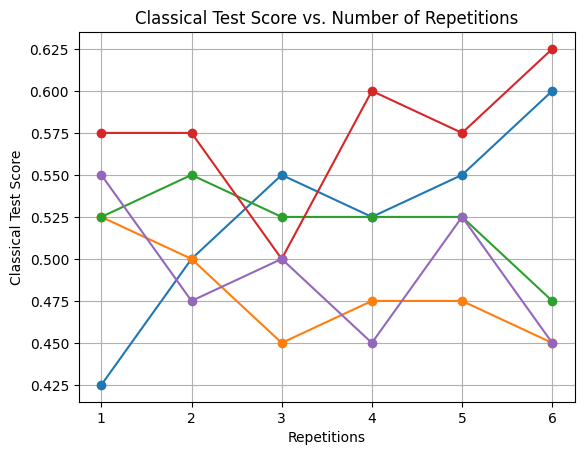

In [73]:
# Plot test scores against repetitions
plt.plot(reps_range, classical_test_scores, marker='o')
plt.xlabel('Repetitions')
plt.ylabel('Classical Test Score')
plt.title('Classical Test Score vs. Number of Repetitions')
plt.grid(True)
plt.show()

## Variational Quantum Classifier trained on Quantum States

In sight of fair comparison between the two implementations, we must make sure that the operations built-in into the Qiskit VQC are, broadly, the same as an in-house development of the VQC. This in-house development is needed due to the difficulty of training the Qiskit VQC with "quantum data", since the training data has to be correctly formatted in terms of a feature map, that would need to be a custom feature map as well — we thus decide to implement it ourselves. 

In [ ]:
# Train-test split
train, test = train_test_split(dataset, test_size=0.2)
quantum_train = train['quantum_state']
quantum_test = test.drop(columns = ['quantum_state'])

X_quantum_train = quantum_train.drop(columns=['label']).values
Y_quantum_train = quantum_train['label'].values

X_quantum_test = quantum_test.drop(columns=['label']).values
Y_quantum_test = quantum_test['label'].values